# Car License Plate Recognition

Datenset für das Training der KFZ-Kennzeichen Erkennung

### Importing Packages

In [2]:
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
from scipy import misc
from skimage import data
import glob
import shutil

print ("TensorFlow Version: {}".format(tf.__version__))

device_name = tf.test.gpu_device_name()

if device_name != "/device:GPU:0":
    raise SystemError("GPU device not found")

print(f"GPU device: {device_name}")

TensorFlow Version: 2.0.0
GPU device: /device:GPU:0


#### Training Parameter

In [3]:
data_path = "D:/development/tensorflow/datasets/alpr"

BATCH_SIZE = 100
NUM_EPOCHS = 500

IMAGE_WIDTH = 128
IMAGE_HEIGHT = 44

POOL_SIZE = 2
MAX_TEXT_LEN = 10

OPTIMIZER = "adagrad"

OUTPUT_PATH = 'output'
MODEL_NAME = "alpr.model"

### Data Loading

In [4]:
from pyimagesearch.io import Hdf5DatasetLoader
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split

loader = Hdf5DatasetLoader()
images, labels = loader.load(data_path + '/hdf5/train.h5', shuffle=True)

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

C:\Users\Andreas\Anaconda3\envs\dl4cv\lib\site-packages\matplotlib\text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


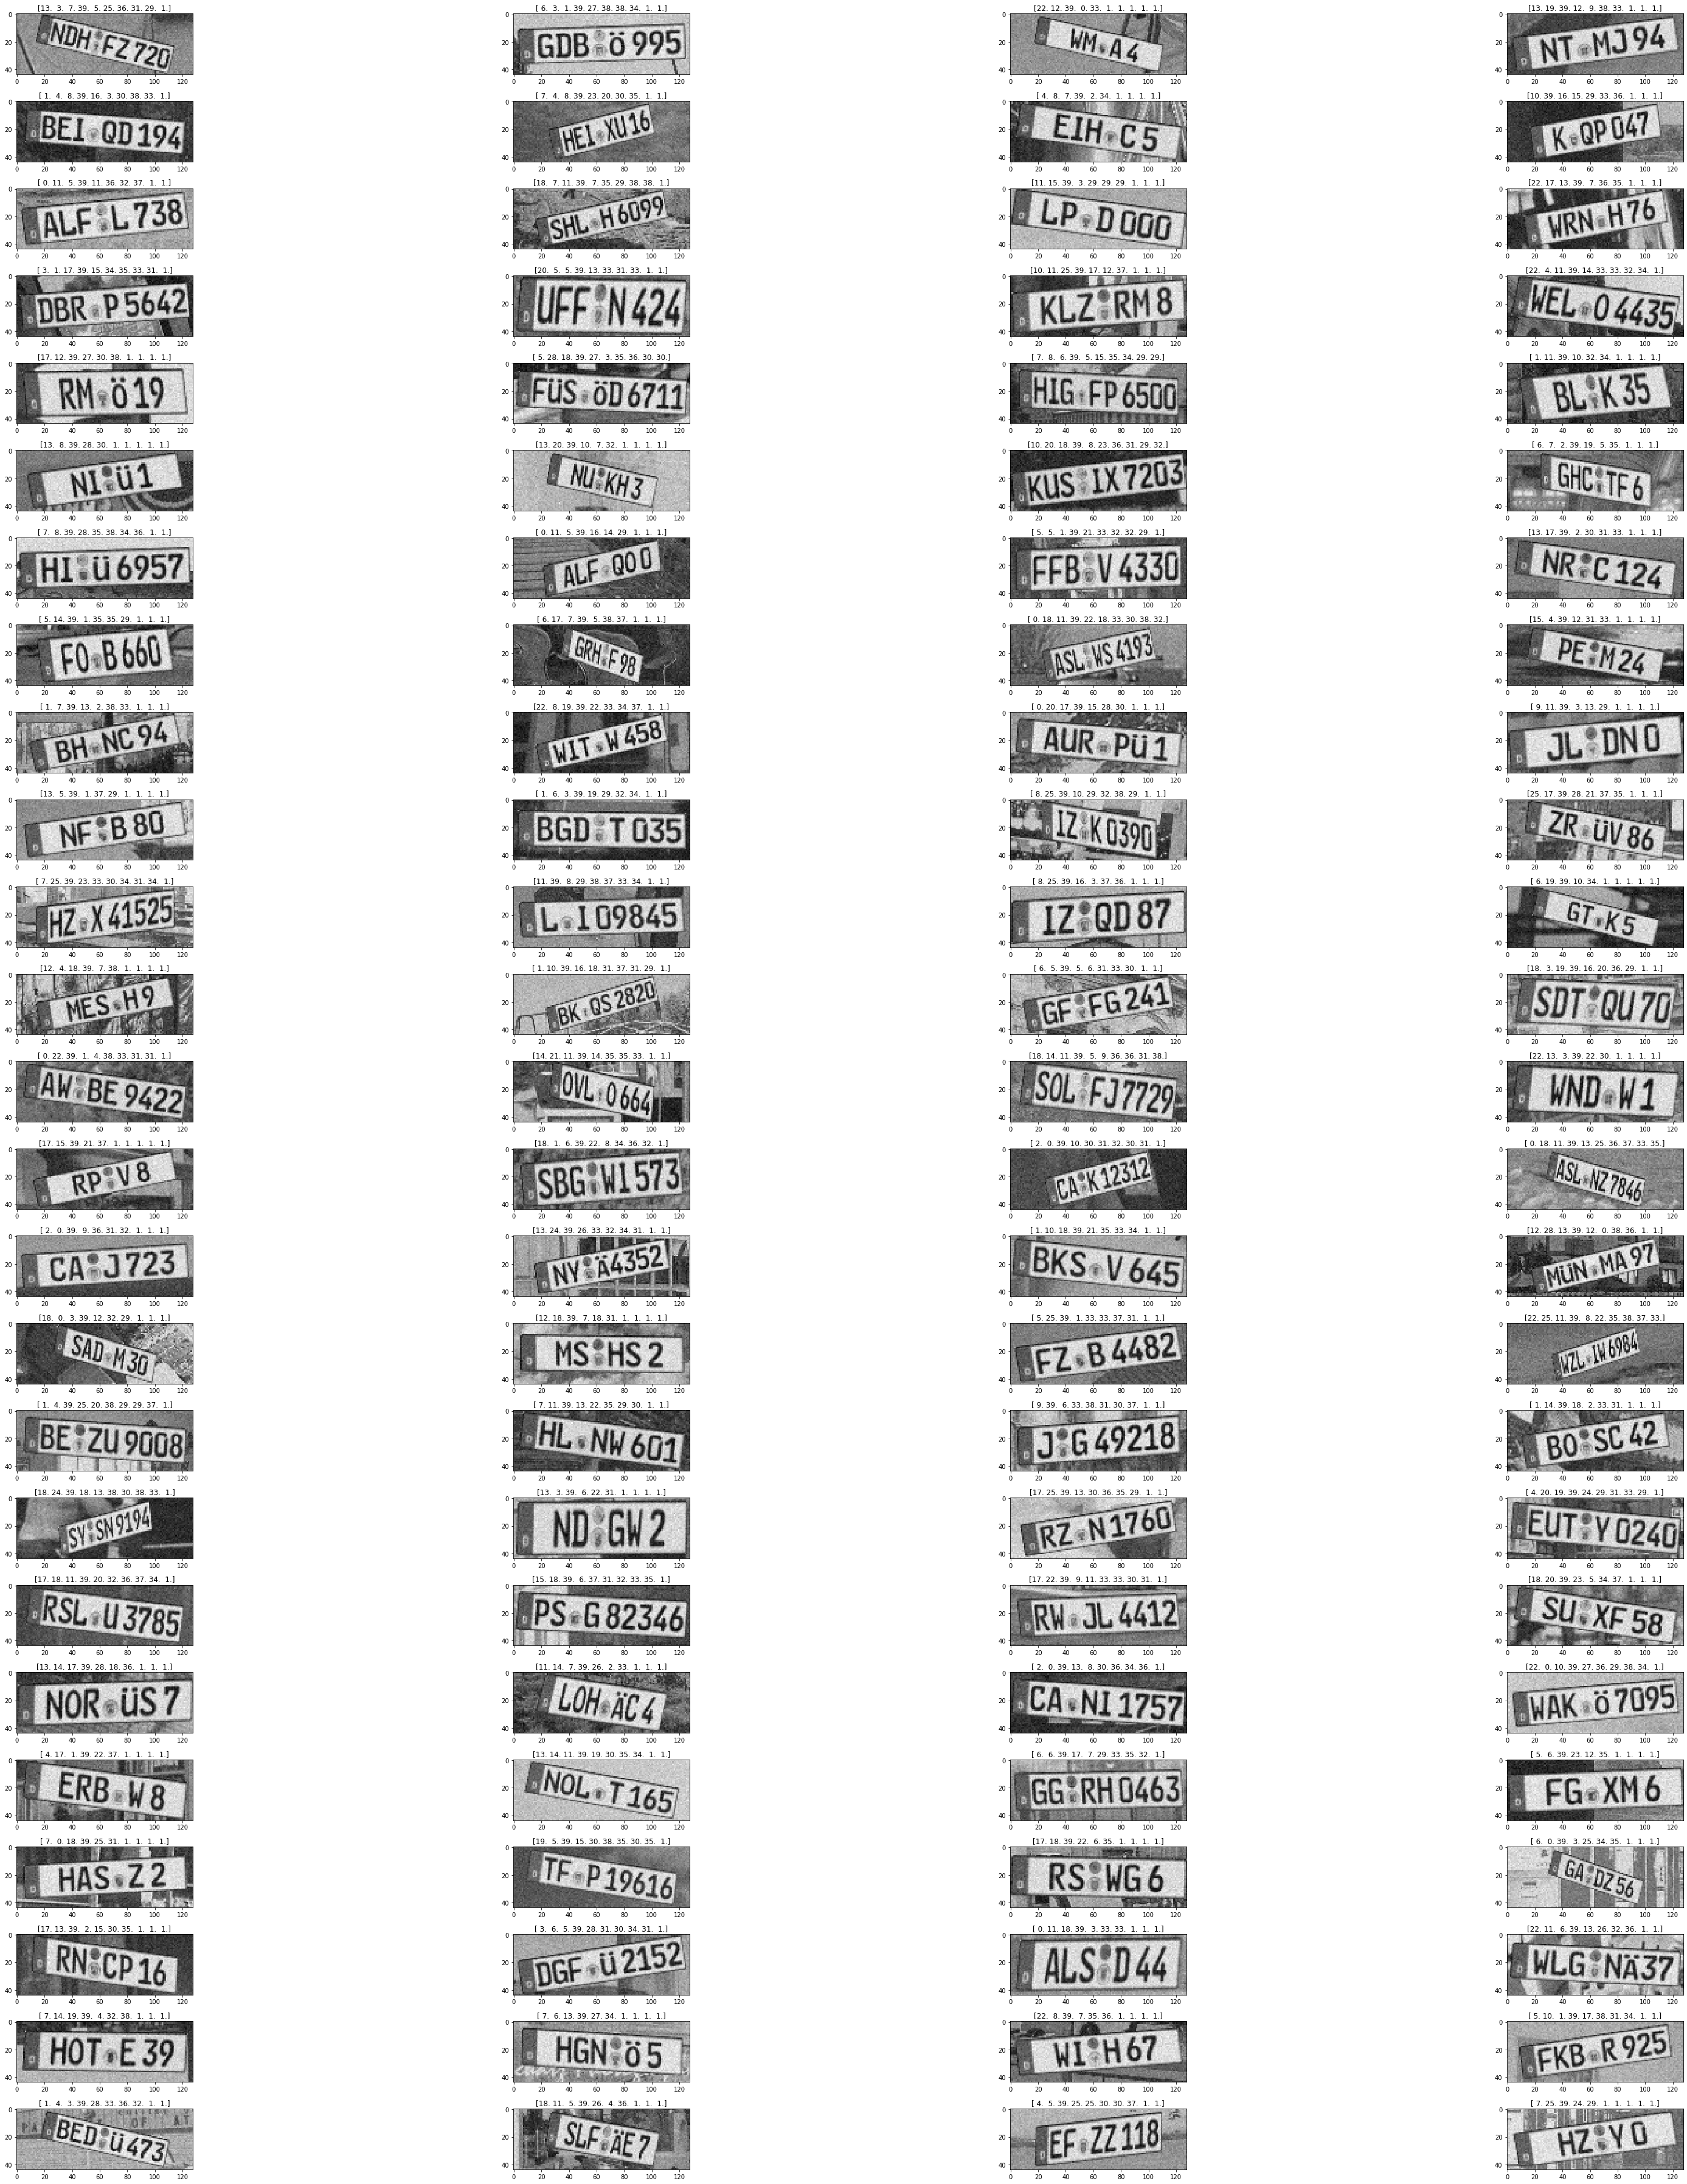

In [5]:
from pyimagesearch.io import Hdf5DatasetLoader
from license_plate_image_augmentor import LicensePlateImageAugmentor
from licence_plate_dataset_generator import LicensePlateDatasetGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from label_codec import LabelCodec
import skimage

loader = Hdf5DatasetLoader()
background_images = loader.load(data_path + '/hdf5/background.h5', shuffle=True, max_items=10000)
    
augmentor = LicensePlateImageAugmentor(IMAGE_WIDTH, IMAGE_HEIGHT, background_images)
train_generator = LicensePlateDatasetGenerator(X_train, y_train, IMAGE_WIDTH, IMAGE_HEIGHT,
                                               POOL_SIZE, MAX_TEXT_LEN, BATCH_SIZE, augmentor)

val_generator = LicensePlateDatasetGenerator(X_test, y_test, IMAGE_WIDTH, IMAGE_HEIGHT,
                                             POOL_SIZE, MAX_TEXT_LEN, BATCH_SIZE, augmentor)

inputs, outputs = next(train_generator.generator())

def plotImages(images_arr, labels, rows, columns):
    fig, axes = plt.subplots(rows, columns, figsize=(50,50))
    axes = axes.flatten()
    for img, label, ax in zip(images_arr, labels, axes):
        img = img.T.reshape(IMAGE_HEIGHT, IMAGE_WIDTH)
        ax.set_title(label)
        ax.imshow(img, cmap='gray')
    plt.tight_layout()
    plt.show()
        
plotImages(inputs["input"], inputs["labels"], int(BATCH_SIZE / 4), 4)

### Create the CNN

In [8]:
from tensorflow.keras import backend as K, Input, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Reshape, Dense, GRU, add, concatenate, Activation, Lambda
from tensorflow.keras.optimizers import SGD, Adam, Adagrad, Adadelta, RMSprop
from pyimagesearch.nn.conv import OCR

def get_optimizer(optimizer_method):
    if optimizer_method == "sdg":
        return SGD(lr=1e-2, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)
    if optimizer_method == "rmsprop":
        return RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
    if optimizer_method == "adam":
        return Adam(lr=0.001, decay=0.001 / config.NUM_EPOCHS)
        # Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    if optimizer_method == "adagrad":
        return Adagrad(lr=0.01, epsilon=1e-08, decay=0.0)
    if optimizer_method == "adadelta":
        return Adadelta(lr=1.0, rho=0.95, epsilon=1e-08, decay=0.0)
    
model = OCR.build(IMAGE_WIDTH, IMAGE_HEIGHT, POOL_SIZE, train_generator.get_output_size(), MAX_TEXT_LEN)

model.compile(loss={'ctc': lambda y_true, y_pred: y_pred},
              optimizer=get_optimizer(OPTIMIZER),
              metrics=['accuracy'])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 128, 44, 1)] 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 44, 16)  160         input[0][0]                      
__________________________________________________________________________________________________
max1 (MaxPooling2D)             (None, 64, 22, 16)   0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 64, 22, 16)   2320        max1[0][0]                       
____________________________________________________________________________________________

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from pyimagesearch.callbacks import CustomModelCheckpoint

def get_callbacks(output_path, optimizer_method, model_name):
    model_checkpoint_path = os.path.sep.join([output_path, optimizer_method, model_name]) + '.h5'
    
    callbacks = [
        EarlyStopping(monitor='loss', min_delta=0.01, patience=5, mode='min', verbose=1),
        CustomModelCheckpoint(model_to_save=model, filepath=model_checkpoint_path, monitor='loss', verbose=1, save_best_only=True, mode='min', period=1),
        ReduceLROnPlateau(monitor='loss', factor=0.1, patience=2, verbose=1, mode='min', min_delta=0.01, cooldown=0, min_lr=0)]
    return callbacks

In [ ]:
history = model.fit_generator(
    train_generator.generator(),
    steps_per_epoch=train_generator.numImages // BATCH_SIZE,
    validation_data=val_generator.generator(),
    validation_steps=val_generator.numImages // BATCH_SIZE,
    epochs=NUM_EPOCHS,
    callbacks=get_callbacks(OUTPUT_PATH, OPTIMIZER, MODEL_NAME), verbose=1)

Epoch 1/500
521/522 [============================>.] - ETA: 0s - loss: 29.8097 - accuracy: 0.0000e+00
Epoch 00001: loss improved from inf to 29.79969, saving model to output\adagrad\alpr.model.h5
522/522 [==============================] - 123s 235ms/step - loss: 29.7997 - accuracy: 0.0000e+00 - val_loss: 25.6906 - val_accuracy: 0.0000e+00
Epoch 2/500
521/522 [============================>.] - ETA: 0s - loss: 25.6277 - accuracy: 0.0000e+00
Epoch 00002: loss improved from 29.79969 to 25.62699, saving model to output\adagrad\alpr.model.h5
522/522 [==============================] - 122s 233ms/step - loss: 25.6270 - accuracy: 0.0000e+00 - val_loss: 25.4905 - val_accuracy: 0.0000e+00
Epoch 3/500
521/522 [============================>.] - ETA: 0s - loss: 25.3045 - accuracy: 0.0000e+00
Epoch 00003: loss improved from 25.62699 to 25.30440, saving model to output\adagrad\alpr.model.h5
522/522 [==============================] - 118s 226ms/step - loss: 25.3044 - accuracy: 0.0000e+00 - val_loss: 25